In [26]:
%pip install -qq -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip -qq install mlrun s3fs seaborn

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dbt-common 1.10.0 requires protobuf<5.0.0,>=4.0.0, but you have protobuf 3.20.3 which is incompatible.
dbt-core 1.8.8 requires protobuf<5,>=4.0.0, but you have protobuf 3.20.3 which is incompatible.


In [250]:
import pandas as pd
from datasets_tourism import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [54]:
START_DATE = "2022-01-01"
END_DATE = "2023-12-31"

# Dati Vodafone

**In vodafone data, first find the locId of locations that are relevant for the "Molveno" use case**
- LAGO_MOLV Lago di Molveno
- 27        Molveno
- 166       Andalo
- 105       Altopiano Paganella ecc..

In [26]:
locId_LAGO_MOLVENO = "LAGO_MOLV"
locId_MOLVENO = "27"
locId_ANDALO = "166"
locID_ALTOPIANO_APT = "105" # Altopiano della Paganella, Rotaliana e San Lorenzo Dorsino

In [228]:
vodafone_lagomolveno = vodafone_attendences_df[
    (vodafone_attendences_ALL_df["locId"] == locId_LAGO_MOLVENO) & 
    (vodafone_attendences_ALL_df["date"] >= START_DATE) &
    (vodafone_attendences_ALL_df["date"] <= END_DATE)
]
vodafone_andalo = vodafone_attendences_df[
    (vodafone_attendences_ALL_df["locId"] == locId_ANDALO) &
    (vodafone_attendences_ALL_df["date"] >= START_DATE) &
    (vodafone_attendences_ALL_df["date"] <= END_DATE)
]
vodafone_apt = vodafone_attendences_df[
    (vodafone_attendences_ALL_df["locId"] == locID_ALTOPIANO_APT) &
    (vodafone_attendences_ALL_df["date"] >= START_DATE) &
    (vodafone_attendences_ALL_df["date"] <= END_DATE)
]

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.


In [229]:
vodafone_apt

,date,locType,locId,userCountry,userProfile,userCluster,value
4621,2022-01-01,TN_MKT_AM_22,105,ALB,TOURIST,None,115
4622,2022-01-01,TN_MKT_AM_22,105,ALB,VISITOR,None,0
4623,2022-01-01,TN_MKT_AM_22,105,ARE,VISITOR,None,0
4624,2022-01-01,TN_MKT_AM_22,105,ARG,TOURIST,None,0
4625,2022-01-01,TN_MKT_AM_22,105,AUS,VISITOR,None,0
...,...,...,...,...,...,...,...
4101397,2023-12-31,TN_MKT_AM_22,105,TWN,TOURIST,None,0
4101398,2023-12-31,TN_MKT_AM_22,105,UKR,COMMUTER,None,0
4101399,2023-12-31,TN_MKT_AM_22,105,UKR,VISITOR,None,0
4101400,2023-12-31,TN_MKT_AM_22,105,USA,TOURIST,None,36


In [230]:
vodafone_apt_tourists = vodafone_apt[vodafone_apt["userProfile"] == "TOURIST"].groupby("date").sum().reset_index()[["date", "value"]]

In [231]:
vodafone_apt_tourists["date"] = pd.to_datetime(vodafone_apt_tourists["date"])
vodafone_apt_tourists.dtypes

date     datetime64[ns]
value             int64
dtype: object

# Movimento turistico APT

## Daily granularity (2022- 2023)

In [261]:
concat_df = pd.concat([vodafone_apt_tourists.set_index("date"), movimento_turistico_df.set_index("giorno")], axis=1).reset_index()
concat_df = concat_df[["index", "value", "presenze"]].rename(columns={"value": "presenze_turistiche_vodafone", "presenze": "movimento_turistico", "index": "date"})
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
concat_df["vodafone_scaled_minmax"] = minmax_scaler.fit_transform(concat_df[["presenze_turistiche_vodafone"]])
concat_df["movimento_scaled_minmax"] = minmax_scaler.fit_transform(concat_df[["movimento_turistico"]])

concat_df["vodafone_scaled_std"] = standard_scaler.fit_transform(concat_df[["presenze_turistiche_vodafone"]])
concat_df["movimento_scaled_std"] = standard_scaler.fit_transform(concat_df[["movimento_turistico"]])
concat_df

,date,presenze_turistiche_vodafone,movimento_turistico,vodafone_scaled_minmax,movimento_scaled_minmax,vodafone_scaled_std,movimento_scaled_std
0,2022-01-01,18954,9433,0.847123,0.795278,2.269227,1.423057
1,2022-01-02,19847,8585,0.892119,0.722731,2.458781,1.185525
2,2022-01-03,15849,8712,0.690668,0.733596,1.610139,1.221099
3,2022-01-04,14960,8534,0.645873,0.718368,1.421434,1.171239
4,2022-01-05,14766,8464,0.636098,0.712379,1.380254,1.151632
...,...,...,...,...,...,...,...
725,2023-12-27,13844,8765,0.589640,0.738130,1.184544,1.235944
726,2023-12-28,15166,9418,0.656253,0.793994,1.465161,1.418855
727,2023-12-29,16680,9996,0.732541,0.843443,1.786532,1.580758
728,2023-12-30,18630,10525,0.830797,0.888699,2.200452,1.728936


<Axes: xlabel='giorno'>

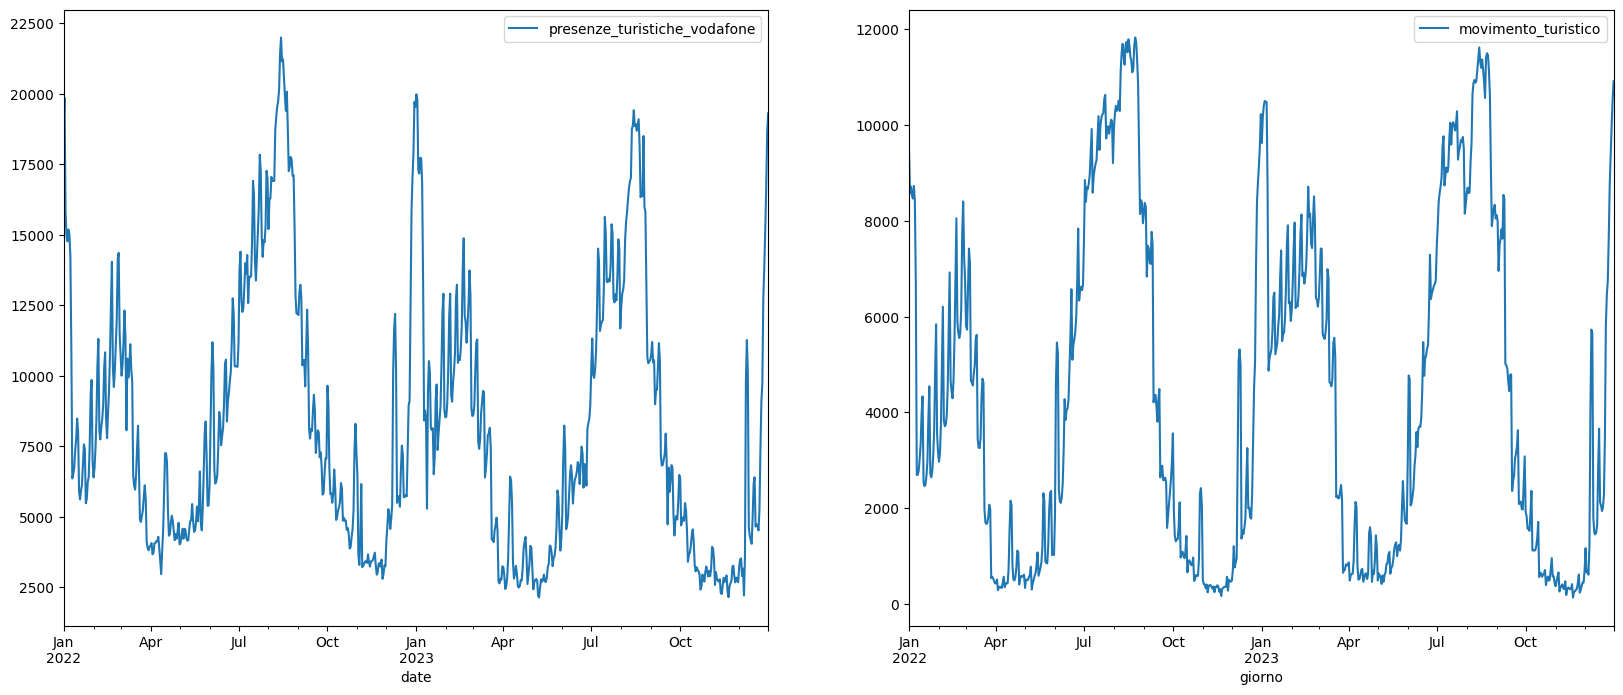

In [249]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
vodafone_apt_tourists.plot(x="date", y="value", label="presenze_turistiche_vodafone", ax=axes[0])
movimento_turistico_df.plot(y="presenze", x="giorno", label="movimento_turistico", ax=axes[1])
#sns.histplot(vodafone_apt_tourists, x="value", ax=axes[1, 0], label="vodafone")
#sns.histplot(concat_df, x="presenze_turistiche", ax=axes[1, 0], label="movimento_turistico")

Original data

<Axes: xlabel='date'>

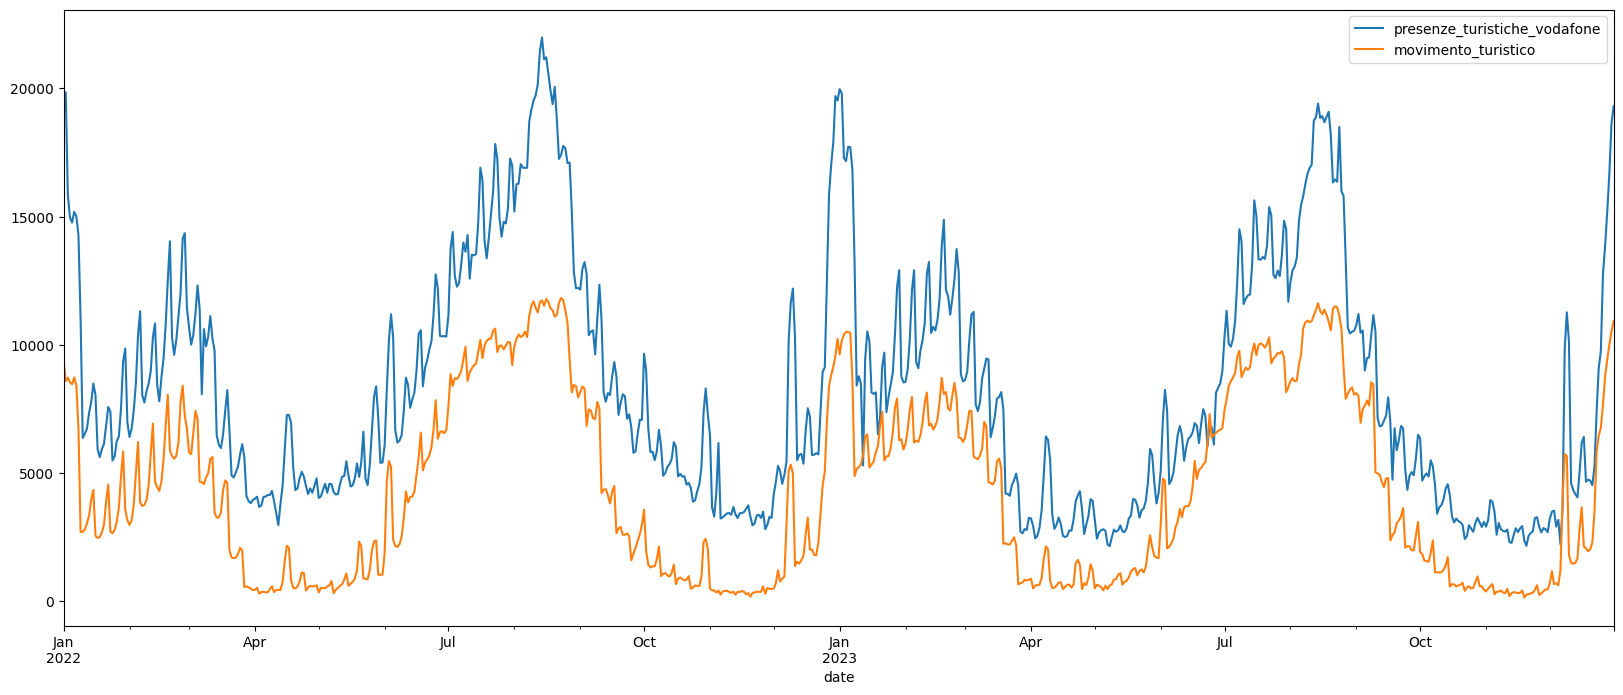

In [259]:
concat_df.plot(x="date", y=["presenze_turistiche_vodafone", "movimento_turistico"], figsize=(20, 8))

Min Max normalization

<Axes: xlabel='date'>

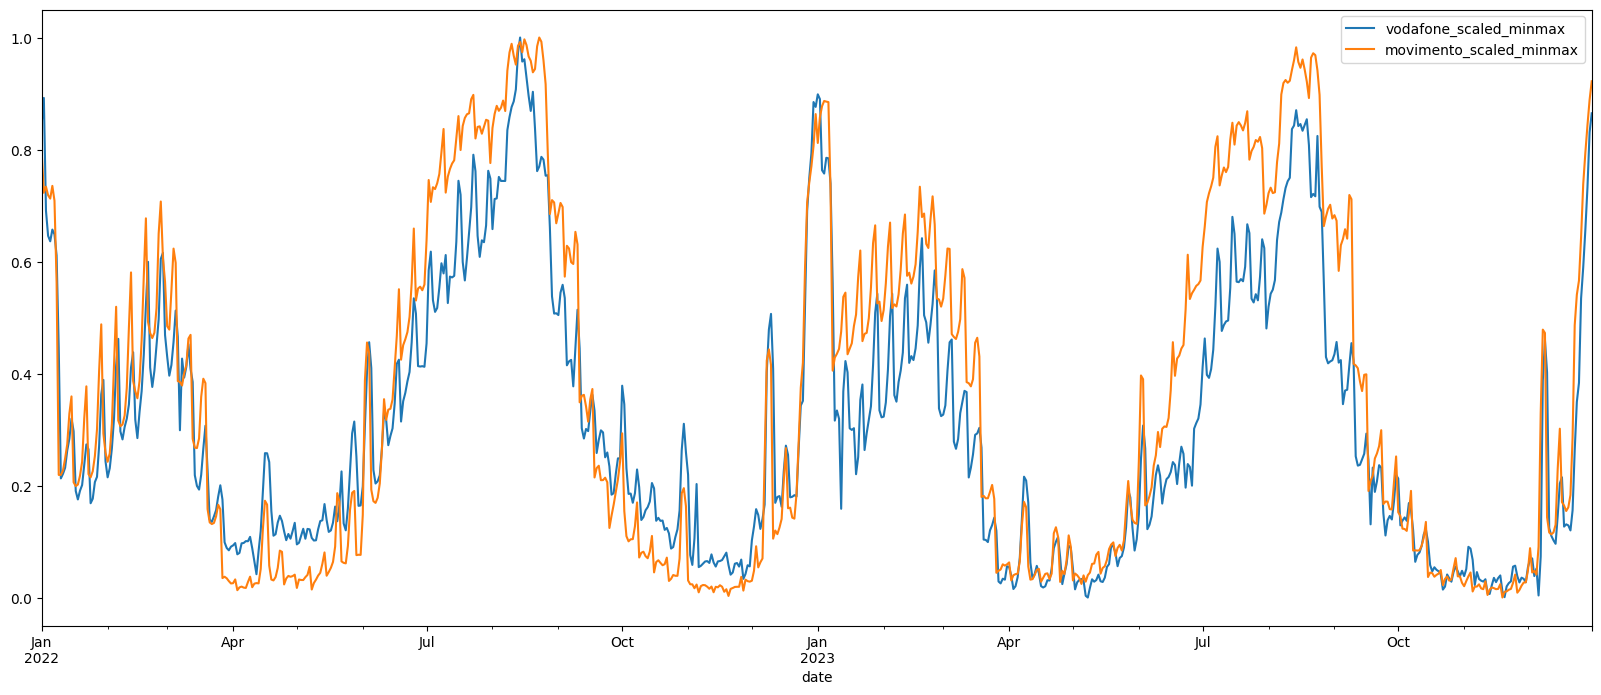

In [257]:
concat_df.plot(x="date", y=["vodafone_scaled_minmax", "movimento_scaled_minmax"], figsize=(20, 8))

Standard deviation

<Axes: xlabel='date'>

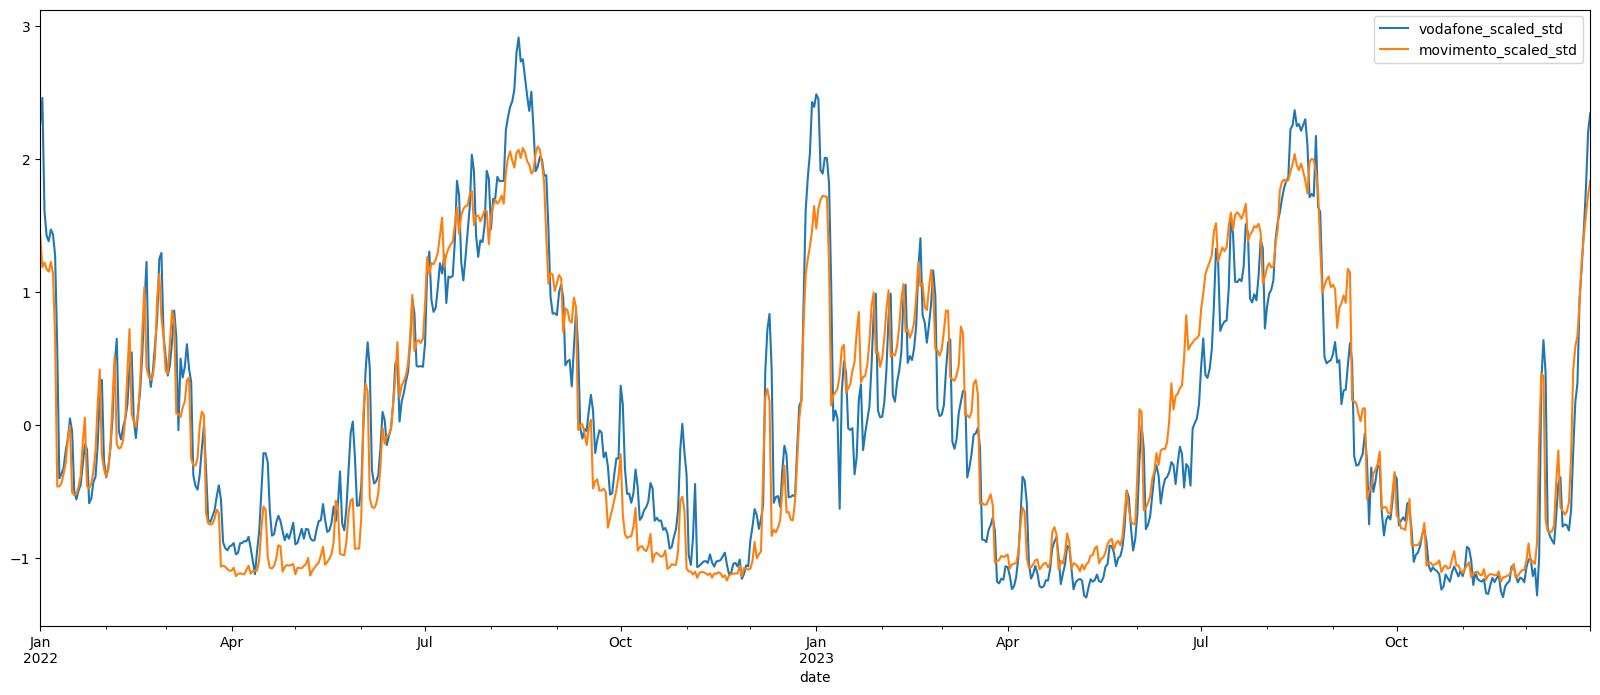

In [258]:
concat_df.plot(x="date", y=["vodafone_scaled_std", "movimento_scaled_std"], figsize=(20, 8))

In [235]:
movimento_turistico_df.describe()

,giorno,arrivi,presenze
count,730,730.000000,730.000000
mean,2022-12-31 12:00:00,1066.556164,4352.626027
min,2022-01-01 00:00:00,28.000000,137.000000
25%,2022-07-02 06:00:00,291.250000,883.500000
50%,2022-12-31 12:00:00,791.000000,3414.000000
75%,2023-07-01 18:00:00,1406.000000,7422.750000
max,2023-12-31 00:00:00,6236.000000,11826.000000
std,NaN,1018.508473,3572.490345


In [ ]:
# usa hist di matplotlib

(array([156.,  68.,  42.,  52.,  33.,  21.,  20.,  33.,  24.,  36.,  25.,
         31.,  21.,  24.,  35.,  20.,  28.,  25.,  14.,  22.]),
 array([  137.  ,   721.45,  1305.9 ,  1890.35,  2474.8 ,  3059.25,
         3643.7 ,  4228.15,  4812.6 ,  5397.05,  5981.5 ,  6565.95,
         7150.4 ,  7734.85,  8319.3 ,  8903.75,  9488.2 , 10072.65,
        10657.1 , 11241.55, 11826.  ]),
 <BarContainer object of 20 artists>)

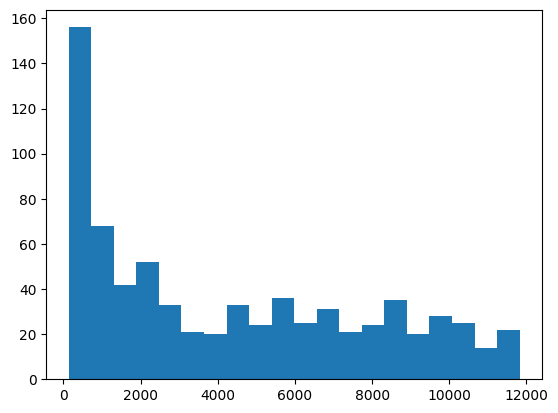

In [247]:
plt.hist(data=movimento_turistico_df, x="presenze", bins=20, histtype="barstacked")

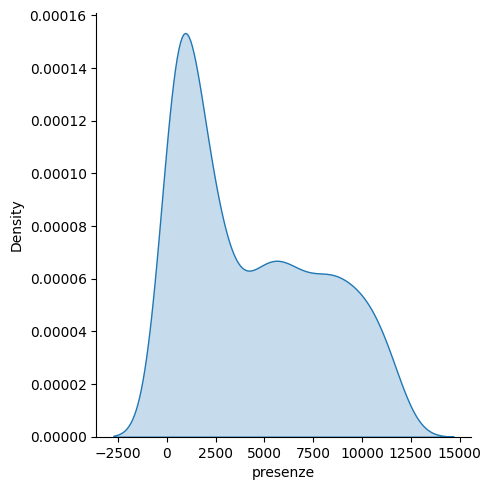

In [236]:
sns.displot(movimento_turistico_df, x="presenze", kind="kde", fill=True)

In [237]:
vodafone_apt_tourists.describe()

,date,value
count,730,730.000000
mean,2022-12-31 12:00:00,8263.546575
min,2022-01-01 00:00:00,2142.000000
25%,2022-07-02 06:00:00,4381.500000
50%,2022-12-31 12:00:00,7072.000000
75%,2023-07-01 18:00:00,11169.000000
max,2023-12-31 00:00:00,21988.000000
std,NaN,4714.285589


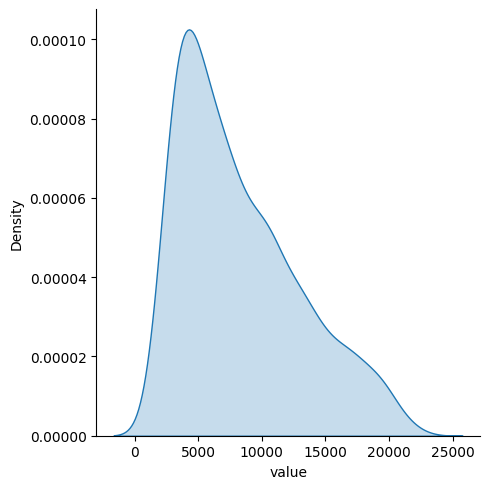

In [238]:
sns.displot(vodafone_apt_tourists, x="value", kind="kde", fill=True)

<Axes: ylabel='Density'>

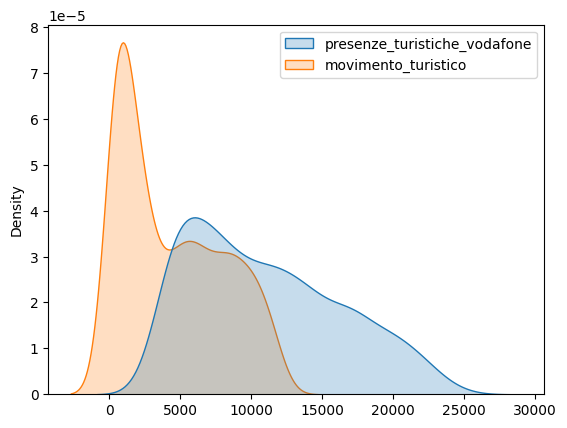

In [138]:
sns.kdeplot(data=concat_df[["presenze_turistiche_vodafone", "movimento_turistico"]], fill=True)

Question: 

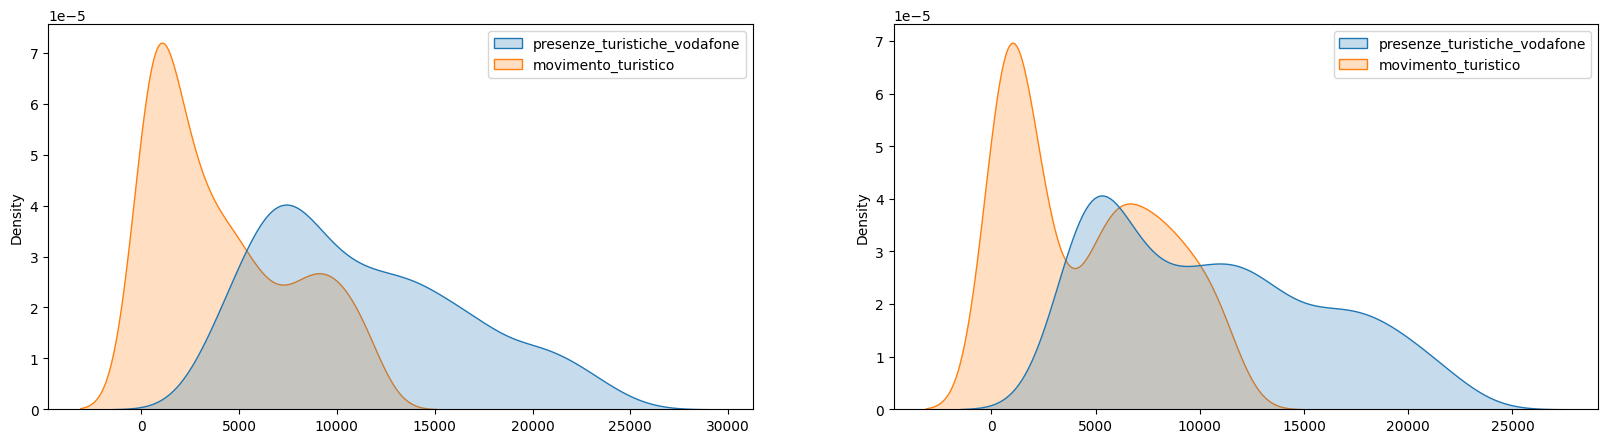

In [227]:
presences_2022_df = concat_df[(concat_df["date"] >= "2022-01-01") & (concat_df["date"] <= "2022-12-31")]
presences_2023_df = concat_df[(concat_df["date"] >= "2023-01-01") & (concat_df["date"] <= "2023-12-31")]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.kdeplot(data=presences_2022_df[["presenze_turistiche_vodafone", "movimento_turistico"]], fill=True, label=["2022"], ax=axes[0])
sns.kdeplot(data=presences_2023_df[["presenze_turistiche_vodafone", "movimento_turistico"]], fill=True, ax=axes[1])
plt.show()

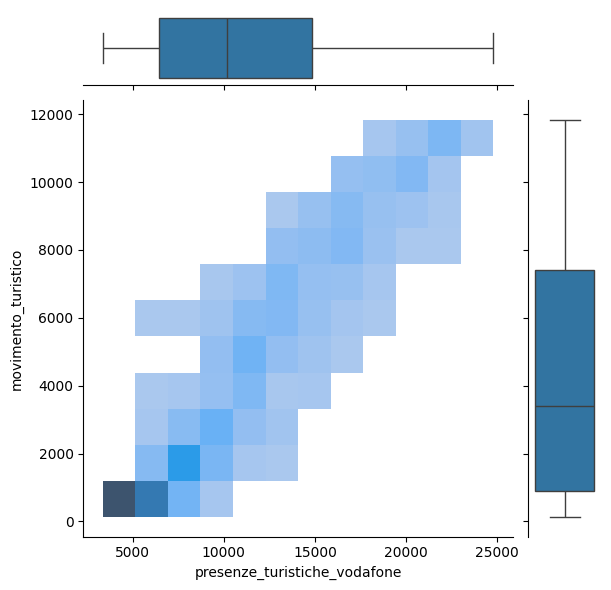

In [169]:
g = sns.JointGrid(data=concat_df, x="presenze_turistiche_vodafone", y="movimento_turistico")
g.plot_joint(sns.histplot)
g.plot_marginals(sns.boxplot)

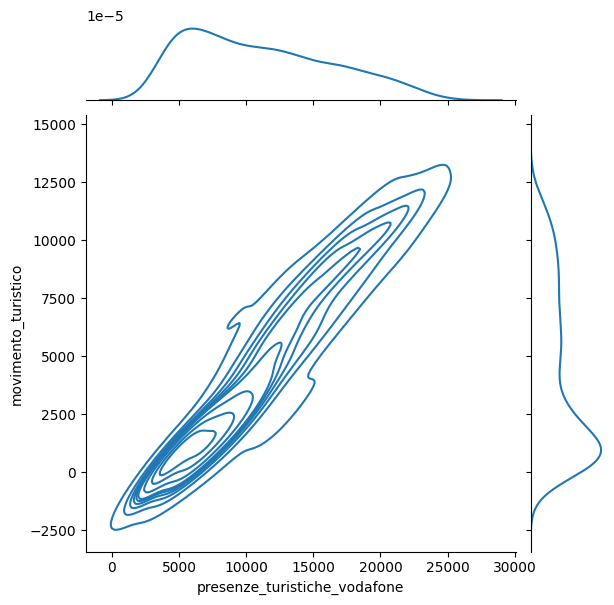

In [171]:
sns.jointplot(
    data=concat_df,
    x="presenze_turistiche_vodafone", y="movimento_turistico",
    kind="kde"
)

## ISPAT Monthly granularity

In [220]:
monthly_movimento_tourists = pd.read_csv("data/ambito_paganella.csv")
monthly_movimento_tourists.columns = ['month', 'value_extra_alberghieri', 'value_alberghieri']
monthly_movimento_tourists["tot_turisti"] = monthly_movimento_tourists["value_extra_alberghieri"].add(monthly_movimento_tourists["value_alberghieri"])
vodafone_2023 = vodafone_attendences_ALL_df[
    (vodafone_attendences_ALL_df["locId"] == locID_ALTOPIANO_APT) &
    (vodafone_attendences_ALL_df["date"] >= "2023-01-01") &
    (vodafone_attendences_ALL_df["date"] <= "2023-12-31")
]
vodafone_2023["date"] = pd.to_datetime(vodafone_2023["date"])
vodafone_2023["month"] = vodafone_2023["date"].dt.month
vodafone_2023 = vodafone_2023[vodafone_2023["userProfile"] == "TOURIST"][["month", "value"]].groupby("month").sum().reset_index()[["month", "value"]]
both_datasets_monthly = pd.concat([monthly_movimento_tourists.set_index("month"), vodafone_2023.set_index("month")], axis=1).reset_index()
both_datasets_monthly = both_datasets_monthly[["month", "tot_turisti", "value"]].rename(columns={"tot_turisti": "movimento_turistico", "value": "presenze_turistiche_vodafone"})
both_datasets_monthly


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,month,movimento_turistico,presenze_turistiche_vodafone
0,1,205252,445337
1,2,194805,450571
2,3,118269,296929
3,4,17159,161215
4,5,18075,174005
5,6,120510,292566
6,7,257604,508452
7,8,280860,584761
8,9,120918,338757
9,10,22395,187825


<Axes: xlabel='month'>

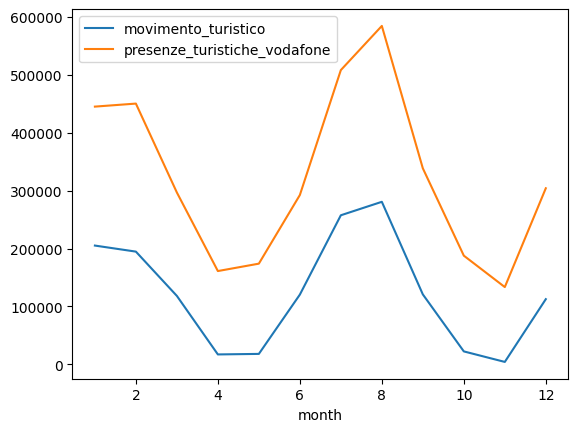

In [221]:
both_datasets_monthly.plot(x="month")

In [ ]:
# un altro modo di rappresentare usa matplotlib

<Axes: ylabel='Density'>

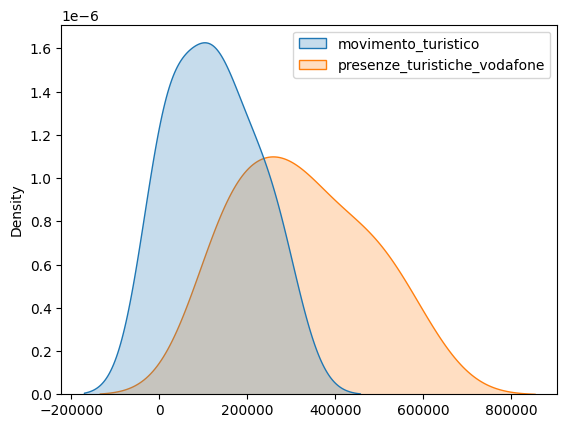

In [226]:
sns.kdeplot(data=both_datasets_monthly[["movimento_turistico", "presenze_turistiche_vodafone"]], fill=True)

# Movimento turistico Molveno

In [23]:
movimento_turistico_molveno_df

,anno,mese,date,territorio_comunale,arrivi,presenze
0,2022,01,2022-01-01,MOLVENO,303,2102
1,2022,01,2022-01-02,MOLVENO,829,1783
2,2022,01,2022-01-03,MOLVENO,479,1787
3,2022,01,2022-01-04,MOLVENO,209,1748
4,2022,01,2022-01-05,MOLVENO,320,1649
...,...,...,...,...,...,...
725,2023,12,2023-12-27,MOLVENO,606,1494
726,2023,12,2023-12-28,MOLVENO,581,1802
727,2023,12,2023-12-29,MOLVENO,725,2138
728,2023,12,2023-12-30,MOLVENO,855,2371
